In [1]:
# Quick summary of results (run this after all training is complete)
import pandas as pd

# Results from training (copy these values from previous executions)
test_acc = 91.75  # Baseline
test_loss = 0.3818
test_acc_tri = 91.41  # Triangular CLR
test_loss_tri = 0.2765
test_acc_one = 92.46  # One-Cycle
test_loss_one = 0.3611

# Create summary table
summary_data = {
    'Method': ['Baseline (Fixed LR)', 'Triangular CLR', 'One-Cycle Policy'],
    'Test Loss': [test_loss, test_loss_tri, test_loss_one],
    'Test Acc (%)': [test_acc, test_acc_tri, test_acc_one]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*90)
print("📊 FINAL RESULTS SUMMARY")
print("="*90)
print(summary_df.to_string(index=False))
print("="*90)

# Find best method
best_idx = summary_df['Test Acc (%)'].idxmax()
best_method = summary_df.loc[best_idx, 'Method']
best_acc = summary_df.loc[best_idx, 'Test Acc (%)']

print(f"\n🏆 Best Method: {best_method} with Test Accuracy: {best_acc:.2f}%")
print("="*90)


📊 FINAL RESULTS SUMMARY
             Method  Test Loss  Test Acc (%)
Baseline (Fixed LR)     0.3818         91.75
     Triangular CLR     0.2765         91.41
   One-Cycle Policy     0.3611         92.46

🏆 Best Method: One-Cycle Policy with Test Accuracy: 92.46%


# Cyclic Learning Rate Assignment
## Tasks:
1. Dataset & Baseline Model
2. LR Range Test
3. Cyclic Learning Rate Implementation

**Dataset**: Fashion-MNIST

## Assignment Overview

This assignment explores **Cyclic Learning Rate (CLR)** policies for training deep neural networks on the Fashion-MNIST dataset. 

### Objectives:
1. **Establish Baseline**: Train a CNN with fixed learning rate
2. **Find Optimal LR Range**: Use LR range test to identify best learning rates
3. **Apply CLR Policies**: Implement and compare Triangular and One-Cycle policies

### Why Cyclic Learning Rates?
- Fixed learning rates can get stuck in local minima
- CLR periodically varies LR between bounds, helping escape saddle points
- Can achieve better accuracy with fewer epochs
- Reduces need for extensive LR tuning

## Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import copy

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Task 1: Dataset & Baseline Model

### 1.1 Load and Prepare Fashion-MNIST Dataset

In [2]:
# Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion-MNIST dataset
full_train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Split training data into train and validation sets (80-20 split)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training samples: 48000
Validation samples: 12000
Test samples: 10000


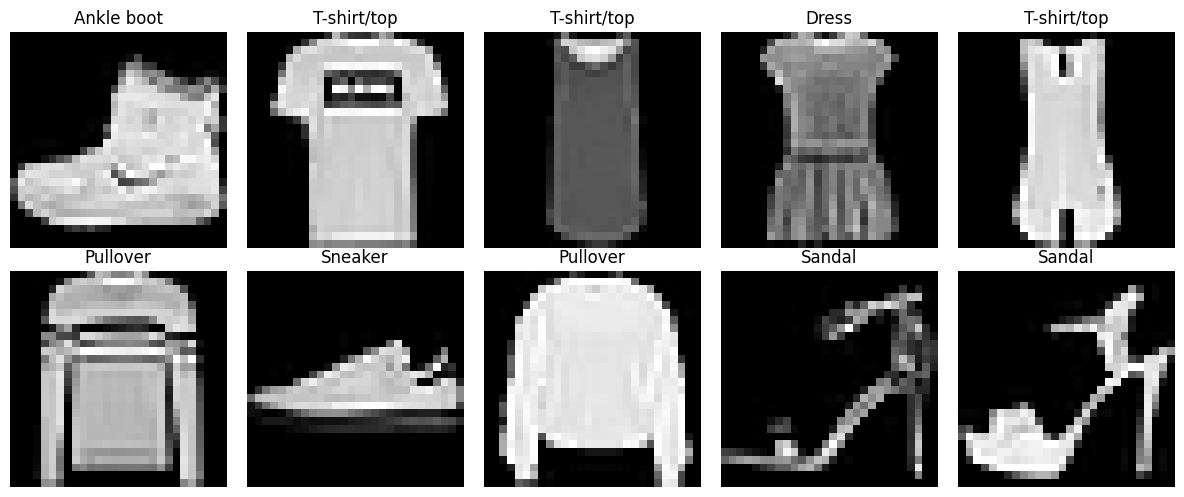

In [3]:
# Visualize some samples
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = full_train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(class_names[label])
    ax.axis('off')
plt.tight_layout()
plt.show()

**Fashion-MNIST Dataset:**
- 70,000 grayscale images (28×28 pixels)
- 10 classes of clothing items
- Split: 48,000 training / 12,000 validation / 10,000 test samples
- Normalized pixel values to [-1, 1] range for better convergence

### 1.2 Define CNN Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling and normalization
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Conv block 1
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # 28x28 -> 14x14
        
        # Conv block 2
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # 14x14 -> 7x7
        
        # Conv block 3
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)  # 7x7 -> 3x3
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Create model instance
model = SimpleCNN().to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

Total parameters: 390,858


**CNN Architecture:**
- 3 Convolutional blocks with Batch Normalization
- MaxPooling for downsampling
- 2 Fully connected layers with Dropout (0.5)
- ~391K trainable parameters
- Suitable for Fashion-MNIST's complexity

### 1.3 Training and Evaluation Functions

In [5]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(loader, desc='Training', leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

**Helper Functions:**
These functions will be reused throughout the assignment for:
- `train_epoch()`: Train model for one epoch and return loss/accuracy
- `validate()`: Evaluate model on validation/test set without gradient updates

### 1.4 Train Baseline Model with Fixed Learning Rate

In [6]:
# Hyperparameters for baseline
baseline_lr = 0.001
num_epochs = 20

# Initialize model, criterion, and optimizer
baseline_model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=baseline_lr)

# Training history
baseline_history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print(f"Training Baseline Model with Fixed LR = {baseline_lr}")
print("-" * 70)

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(baseline_model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(baseline_model, val_loader, criterion, device)
    
    # Store history
    baseline_history['train_loss'].append(train_loss)
    baseline_history['train_acc'].append(train_acc)
    baseline_history['val_loss'].append(val_loss)
    baseline_history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print()

# Test performance
test_loss, test_acc = validate(baseline_model, test_loader, criterion, device)
print("=" * 70)
print(f"Final Test Results - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
print("=" * 70)

Training Baseline Model with Fixed LR = 0.001
----------------------------------------------------------------------


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 0.4589, Train Acc: 83.49%
  Val Loss: 0.3165, Val Acc: 88.25%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/20:
  Train Loss: 0.2927, Train Acc: 89.43%
  Val Loss: 0.2882, Val Acc: 89.37%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/20:
  Train Loss: 0.2494, Train Acc: 90.97%
  Val Loss: 0.2270, Val Acc: 91.80%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/20:
  Train Loss: 0.2169, Train Acc: 92.27%
  Val Loss: 0.2208, Val Acc: 92.08%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/20:
  Train Loss: 0.1944, Train Acc: 92.97%
  Val Loss: 0.2234, Val Acc: 91.74%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6/20:
  Train Loss: 0.1732, Train Acc: 93.61%
  Val Loss: 0.2174, Val Acc: 92.28%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7/20:
  Train Loss: 0.1540, Train Acc: 94.32%
  Val Loss: 0.2106, Val Acc: 92.55%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8/20:
  Train Loss: 0.1403, Train Acc: 94.82%
  Val Loss: 0.2232, Val Acc: 92.46%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9/20:
  Train Loss: 0.1276, Train Acc: 95.23%
  Val Loss: 0.2246, Val Acc: 92.42%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10/20:
  Train Loss: 0.1119, Train Acc: 95.79%
  Val Loss: 0.2118, Val Acc: 92.84%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11/20:
  Train Loss: 0.1013, Train Acc: 96.26%
  Val Loss: 0.2320, Val Acc: 92.61%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12/20:
  Train Loss: 0.0907, Train Acc: 96.66%
  Val Loss: 0.2449, Val Acc: 92.34%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 13/20:
  Train Loss: 0.0787, Train Acc: 97.11%
  Val Loss: 0.2427, Val Acc: 92.47%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 14/20:
  Train Loss: 0.0710, Train Acc: 97.37%
  Val Loss: 0.2598, Val Acc: 92.42%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 15/20:
  Train Loss: 0.0663, Train Acc: 97.62%
  Val Loss: 0.2785, Val Acc: 92.22%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 16/20:
  Train Loss: 0.0646, Train Acc: 97.57%
  Val Loss: 0.2831, Val Acc: 92.35%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 17/20:
  Train Loss: 0.0579, Train Acc: 97.80%
  Val Loss: 0.3116, Val Acc: 92.04%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 18/20:
  Train Loss: 0.0509, Train Acc: 98.12%
  Val Loss: 0.2986, Val Acc: 92.34%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 19/20:
  Train Loss: 0.0475, Train Acc: 98.24%
  Val Loss: 0.3068, Val Acc: 92.29%



Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 20/20:
  Train Loss: 0.0447, Train Acc: 98.39%
  Val Loss: 0.3401, Val Acc: 92.14%

Final Test Results - Loss: 0.3818, Accuracy: 91.75%


**Baseline Training Configuration:**
- Fixed learning rate: 0.001
- Optimizer: Adam
- Loss function: Cross Entropy
- Epochs: 20
- This establishes our performance benchmark

### 1.5 Plot Baseline Training Results

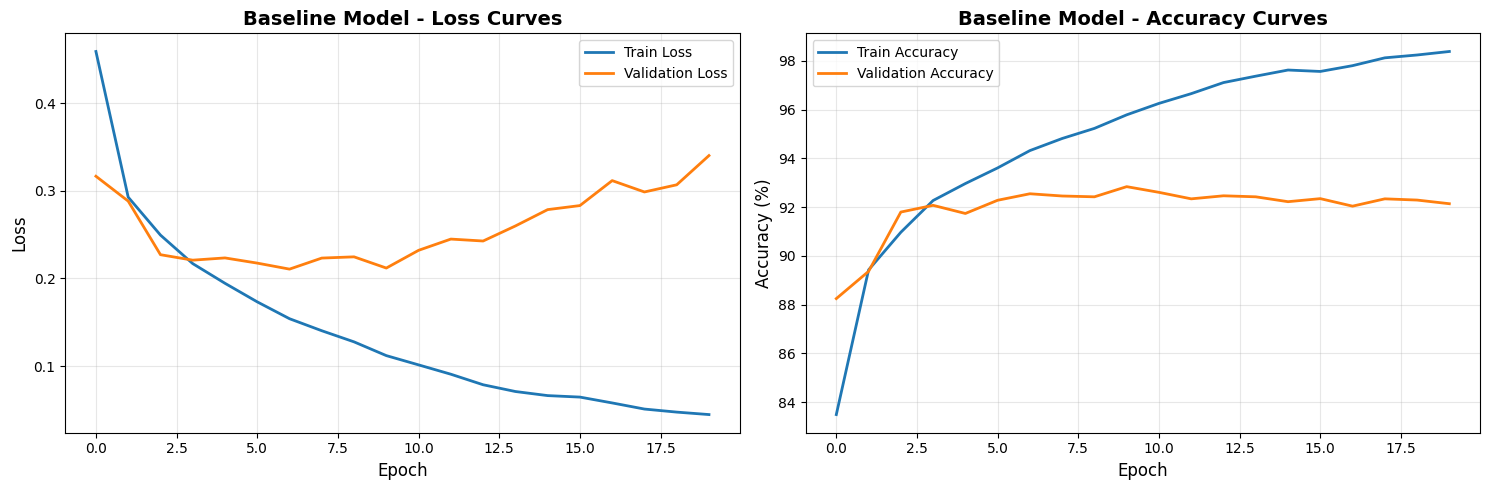


📊 BASELINE MODEL SUMMARY
Fixed Learning Rate: 0.001
Final Train Loss: 0.0447
Final Train Accuracy: 98.39%
Final Val Loss: 0.3401
Final Val Accuracy: 92.14%
Test Loss: 0.3818
Test Accuracy: 91.75%


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(baseline_history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(baseline_history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Baseline Model - Loss Curves', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(baseline_history['train_acc'], label='Train Accuracy', linewidth=2)
ax2.plot(baseline_history['val_acc'], label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Baseline Model - Accuracy Curves', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n📊 BASELINE MODEL SUMMARY")
print("=" * 50)
print(f"Fixed Learning Rate: {baseline_lr}")
print(f"Final Train Loss: {baseline_history['train_loss'][-1]:.4f}")
print(f"Final Train Accuracy: {baseline_history['train_acc'][-1]:.2f}%")
print(f"Final Val Loss: {baseline_history['val_loss'][-1]:.4f}")
print(f"Final Val Accuracy: {baseline_history['val_acc'][-1]:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("=" * 50)

## Task 2: LR Range Test

### What is LR Range Test?

The **Learning Rate Range Test** systematically increases the learning rate from very small to very large values during training, recording the loss at each step.

**Purpose:**
- Find the optimal learning rate range for training
- Identify `base_lr`: where loss decreases steadily
- Identify `max_lr`: just before loss explodes

**How to Read the Plot:**
1. **Steepest descent region**: Best single LR (red dot)
2. **base_lr**: 1/10th of steepest point
3. **max_lr**: At steepest point, before loss increases sharply

### 2.1 Implement LR Range Test

In [8]:
class LRRangeFinder:
    """Learning Rate Range Finder"""
    
    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.history = {'lr': [], 'loss': []}
        
    def range_test(self, train_loader, start_lr=1e-7, end_lr=10, num_iter=100, smooth_f=0.05):
        """Perform LR range test"""
        # Save initial model state
        initial_state = copy.deepcopy(self.model.state_dict())
        
        # Calculate multiplication factor
        mult = (end_lr / start_lr) ** (1 / num_iter)
        lr = start_lr
        
        # Update optimizer LR
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        avg_loss = 0.
        best_loss = 0.
        batch_num = 0
        losses = []
        
        # Create iterator
        iterator = iter(train_loader)
        
        self.model.train()
        print("Running LR Range Test...")
        
        for iteration in tqdm(range(num_iter)):
            # Get batch
            try:
                inputs, targets = next(iterator)
            except StopIteration:
                iterator = iter(train_loader)
                inputs, targets = next(iterator)
            
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            
            # Compute smoothed loss
            avg_loss = smooth_f * loss.item() + (1 - smooth_f) * avg_loss
            smoothed_loss = avg_loss / (1 - (1 - smooth_f) ** (batch_num + 1))
            
            # Check if loss is exploding
            if batch_num > 0 and smoothed_loss > 4 * best_loss:
                print(f"\nStopping early at iteration {iteration} - loss is exploding")
                break
            
            # Record best loss
            if smoothed_loss < best_loss or batch_num == 0:
                best_loss = smoothed_loss
            
            # Store values
            self.history['lr'].append(lr)
            self.history['loss'].append(smoothed_loss)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Update learning rate
            lr *= mult
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
            
            batch_num += 1
        
        # Restore initial model state
        self.model.load_state_dict(initial_state)
        print("LR Range Test completed!")
        
    def plot(self, skip_start=10, skip_end=5, log_lr=True):
        """Plot the LR range test results"""
        if skip_start < 0:
            skip_start = 0
        if skip_end < 0:
            skip_end = 0
        
        lrs = self.history['lr'][skip_start:-skip_end] if skip_end > 0 else self.history['lr'][skip_start:]
        losses = self.history['loss'][skip_start:-skip_end] if skip_end > 0 else self.history['loss'][skip_start:]
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(lrs, losses, linewidth=2, color='#2E86AB')
        
        if log_lr:
            ax.set_xscale('log')
        
        ax.set_xlabel('Learning Rate (log scale)', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.set_title('LR Range Test: Loss vs Learning Rate', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Find steepest gradient point
        min_grad_idx = None
        try:
            min_grad_idx = (np.gradient(np.array(losses))).argmin()
        except:
            pass
        
        if min_grad_idx is not None:
            ax.scatter(lrs[min_grad_idx], losses[min_grad_idx], 
                      color='red', s=100, zorder=5, label='Steepest Gradient')
            ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Suggest learning rates
        if min_grad_idx is not None:
            suggested_lr = lrs[min_grad_idx]
            print(f"\n💡 SUGGESTED LEARNING RATES:")
            print(f"   Steepest gradient at: {suggested_lr:.6f}")
            print(f"   Suggested base_lr: {suggested_lr/10:.6f}")
            print(f"   Suggested max_lr: {suggested_lr:.6f}")

**LR Range Finder Implementation:**
- Trains model briefly while exponentially increasing LR
- Uses exponential smoothing to reduce noise
- Stops early if loss explodes (>4x best loss)
- Plots loss vs LR on log scale for analysis

### 2.2 Run LR Range Test

Running LR Range Test...


  0%|          | 0/100 [00:00<?, ?it/s]


Stopping early at iteration 96 - loss is exploding
LR Range Test completed!


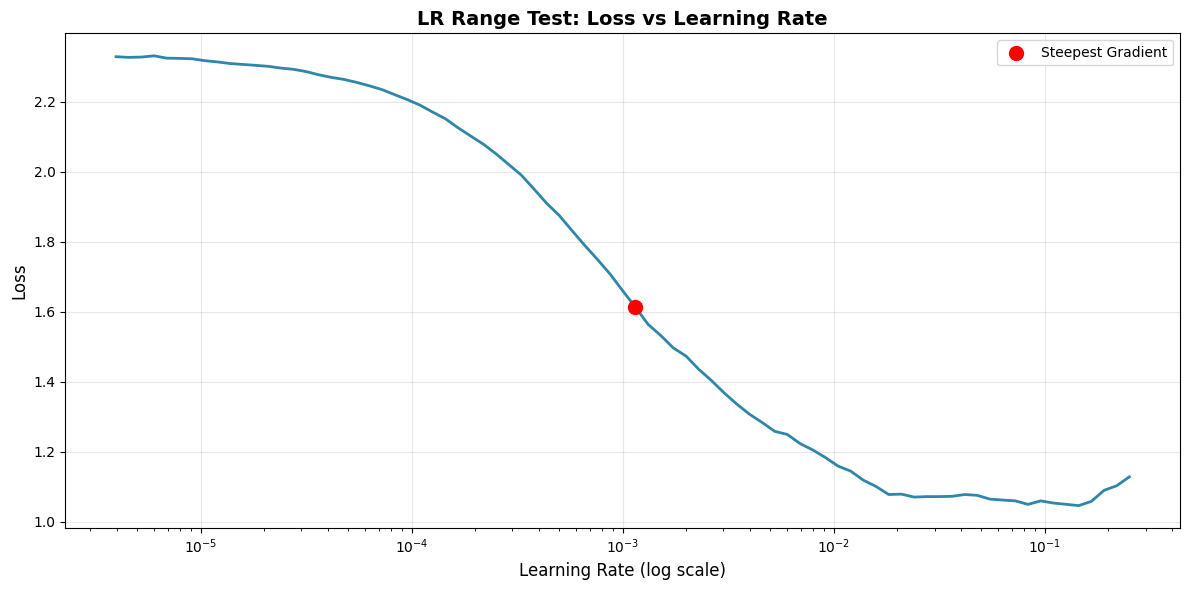


💡 SUGGESTED LEARNING RATES:
   Steepest gradient at: 0.001148
   Suggested base_lr: 0.000115
   Suggested max_lr: 0.001148


In [9]:
# Initialize new model for LR range test
lr_test_model = SimpleCNN().to(device)
lr_test_optimizer = optim.Adam(lr_test_model.parameters(), lr=1e-7)
lr_test_criterion = nn.CrossEntropyLoss()

# Create LR finder
lr_finder = LRRangeFinder(lr_test_model, lr_test_optimizer, lr_test_criterion, device)

# Run range test
lr_finder.range_test(train_loader, start_lr=1e-6, end_lr=1, num_iter=100)

# Plot results
lr_finder.plot(skip_start=10, skip_end=5)

### 2.3 Choose base_lr and max_lr

In [10]:
# Based on the LR range test, choose appropriate values
# Adjust these values based on your plot
base_lr = 1e-5   # Stable low point
max_lr = 1e-3    # Just before loss explodes

print("📌 SELECTED LEARNING RATES FOR CLR:")
print(f"   base_lr: {base_lr}")
print(f"   max_lr: {max_lr}")
print(f"\n   (Adjust these values based on your LR range test plot)")

📌 SELECTED LEARNING RATES FOR CLR:
   base_lr: 1e-05
   max_lr: 0.001

   (Adjust these values based on your LR range test plot)


**Interpreting Results:**
Based on the LR range test plot, we select:
- `base_lr`: Conservative starting point (stable training region)
- `max_lr`: Aggressive upper bound (before instability)
- These values will be used for CLR policies in Task 3

## Task 3: Implement Cyclic Learning Rate

### Understanding Cyclic Learning Rates

**Core Concept:**
Instead of using a fixed learning rate, CLR cyclically varies the LR between `base_lr` and `max_lr` during training.

**Benefits:**
1. **Escape Local Minima**: Higher LR helps jump out of poor solutions
2. **Better Generalization**: Regularization effect from LR variation
3. **Faster Convergence**: Can train with fewer epochs
4. **Robust Performance**: Less sensitive to initial LR choice

**Two Policies We'll Compare:**
1. **Triangular**: Constant amplitude cycles (linear increase/decrease)
2. **One-Cycle**: Single cycle with warm-up phase and long annealing

### 3.1 Cyclic LR Implementation

In [11]:
class CyclicLR:
    """Cyclic Learning Rate Scheduler"""
    
    def __init__(self, optimizer, base_lr, max_lr, step_size, mode='triangular', gamma=1.0):
        """
        Args:
            optimizer: torch optimizer
            base_lr: minimum learning rate
            max_lr: maximum learning rate
            step_size: half of cycle length (in iterations)
            mode: 'triangular', 'triangular2', or 'exp_range'
            gamma: decay factor for triangular2 and exp_range modes
        """
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        self.iteration = 0
        self.cycle = 0
        self.lr_history = []
        
    def step(self):
        """Update learning rate"""
        self.iteration += 1
        cycle = np.floor(1 + self.iteration / (2 * self.step_size))
        x = np.abs(self.iteration / self.step_size - 2 * cycle + 1)
        
        if self.mode == 'triangular':
            scale_fn = 1.0
            lr = self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x)) * scale_fn
            
        elif self.mode == 'triangular2':
            scale_fn = 1 / (2 ** (cycle - 1))
            lr = self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x)) * scale_fn
            
        elif self.mode == 'exp_range':
            scale_fn = self.gamma ** self.iteration
            lr = self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x)) * scale_fn
        
        # Update optimizer
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        self.lr_history.append(lr)
        return lr


class OneCycleLR:
    """One Cycle Learning Rate Policy"""
    
    def __init__(self, optimizer, max_lr, total_steps, pct_start=0.3, div_factor=25., final_div_factor=1e4):
        """
        Args:
            optimizer: torch optimizer
            max_lr: maximum learning rate
            total_steps: total number of training iterations
            pct_start: percentage of cycle spent increasing lr
            div_factor: initial_lr = max_lr / div_factor
            final_div_factor: min_lr = initial_lr / final_div_factor
        """
        self.optimizer = optimizer
        self.max_lr = max_lr
        self.total_steps = total_steps
        self.pct_start = pct_start
        self.initial_lr = max_lr / div_factor
        self.min_lr = self.initial_lr / final_div_factor
        self.step_count = 0
        self.lr_history = []
        
    def step(self):
        """Update learning rate"""
        self.step_count += 1
        
        # Calculate current position in cycle
        step_num = self.step_count
        step_size_up = self.pct_start * self.total_steps
        
        if step_num <= step_size_up:
            # Annealing up
            lr = self.initial_lr + (self.max_lr - self.initial_lr) * step_num / step_size_up
        else:
            # Annealing down
            step_num = step_num - step_size_up
            step_size_down = self.total_steps - step_size_up
            lr = self.max_lr - (self.max_lr - self.min_lr) * step_num / step_size_down
        
        # Update optimizer
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        self.lr_history.append(lr)
        return lr

**Scheduler Classes:**

**CyclicLR:**
- Implements triangular, triangular2, and exp_range policies
- `step_size`: Number of iterations for half a cycle
- LR oscillates between base_lr and max_lr

**OneCycleLR:**
- Single cycle: quick ramp up, slow ramp down
- `pct_start`: Fraction of training for warm-up (default 30%)
- Final phase uses very low LR for fine-tuning

### 3.2 Training Function with CLR

In [12]:
def train_with_clr(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                   num_epochs, device, scheduler_name="CLR"):
    """Train model with cyclic learning rate"""
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }
    
    print(f"\nTraining with {scheduler_name}")
    print("=" * 70)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training
        for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            # Update learning rate
            current_lr = scheduler.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_loss = running_loss / total
        train_acc = 100. * correct / total
        
        # Validation
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"  Current LR: {current_lr:.6f}")
        print()
    
    history['lr'] = scheduler.lr_history
    return history

**Training Function:**
Modified to update learning rate after every batch (not epoch).
This allows fine-grained LR control throughout training.

### 3.3 Train with Triangular Policy

In [13]:
# Model for Triangular CLR
clr_triangular_model = SimpleCNN().to(device)
clr_triangular_optimizer = optim.Adam(clr_triangular_model.parameters(), lr=base_lr)

# Calculate step_size (typically 2-10 times the number of iterations in an epoch)
iterations_per_epoch = len(train_loader)
step_size = 4 * iterations_per_epoch  # 4 epochs per half-cycle

# Create scheduler
clr_triangular_scheduler = CyclicLR(
    clr_triangular_optimizer, 
    base_lr=base_lr, 
    max_lr=max_lr, 
    step_size=step_size,
    mode='triangular'
)

# Train
num_epochs_clr = 20
triangular_history = train_with_clr(
    clr_triangular_model, 
    train_loader, 
    val_loader, 
    criterion, 
    clr_triangular_optimizer, 
    clr_triangular_scheduler,
    num_epochs_clr, 
    device,
    scheduler_name="Triangular CLR"
)

# Test performance
test_loss_tri, test_acc_tri = validate(clr_triangular_model, test_loader, criterion, device)
print("=" * 70)
print(f"Triangular CLR - Test Loss: {test_loss_tri:.4f}, Test Acc: {test_acc_tri:.2f}%")
print("=" * 70)


Training with Triangular CLR


Epoch 1/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 0.9025, Train Acc: 70.10%
  Val Loss: 0.4311, Val Acc: 84.51%
  Current LR: 0.000258



Epoch 2/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/20:
  Train Loss: 0.3790, Train Acc: 86.53%
  Val Loss: 0.3113, Val Acc: 88.83%
  Current LR: 0.000505



Epoch 3/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/20:
  Train Loss: 0.3128, Train Acc: 88.72%
  Val Loss: 0.2784, Val Acc: 89.70%
  Current LR: 0.000753



Epoch 4/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/20:
  Train Loss: 0.2726, Train Acc: 90.13%
  Val Loss: 0.2625, Val Acc: 90.51%
  Current LR: 0.001000



Epoch 5/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/20:
  Train Loss: 0.2347, Train Acc: 91.50%
  Val Loss: 0.2354, Val Acc: 91.41%
  Current LR: 0.000753



Epoch 6/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6/20:
  Train Loss: 0.1962, Train Acc: 92.88%
  Val Loss: 0.2213, Val Acc: 91.93%
  Current LR: 0.000505



Epoch 7/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7/20:
  Train Loss: 0.1571, Train Acc: 94.26%
  Val Loss: 0.2080, Val Acc: 92.72%
  Current LR: 0.000258



Epoch 8/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8/20:
  Train Loss: 0.1195, Train Acc: 95.72%
  Val Loss: 0.1961, Val Acc: 93.08%
  Current LR: 0.000010



Epoch 9/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9/20:
  Train Loss: 0.1106, Train Acc: 96.11%
  Val Loss: 0.2095, Val Acc: 92.49%
  Current LR: 0.000258



Epoch 10/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10/20:
  Train Loss: 0.1310, Train Acc: 95.20%
  Val Loss: 0.2146, Val Acc: 92.26%
  Current LR: 0.000505



Epoch 11/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11/20:
  Train Loss: 0.1467, Train Acc: 94.65%
  Val Loss: 0.2366, Val Acc: 91.87%
  Current LR: 0.000753



Epoch 12/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12/20:
  Train Loss: 0.1607, Train Acc: 94.02%
  Val Loss: 0.2324, Val Acc: 91.97%
  Current LR: 0.001000



Epoch 13/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 13/20:
  Train Loss: 0.1391, Train Acc: 94.82%
  Val Loss: 0.2384, Val Acc: 91.99%
  Current LR: 0.000753



Epoch 14/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 14/20:
  Train Loss: 0.0996, Train Acc: 96.31%
  Val Loss: 0.2465, Val Acc: 92.20%
  Current LR: 0.000505



Epoch 15/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 15/20:
  Train Loss: 0.0681, Train Acc: 97.54%
  Val Loss: 0.2257, Val Acc: 92.98%
  Current LR: 0.000258



Epoch 16/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 16/20:
  Train Loss: 0.0406, Train Acc: 98.59%
  Val Loss: 0.2443, Val Acc: 93.26%
  Current LR: 0.000010



Epoch 17/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 17/20:
  Train Loss: 0.0323, Train Acc: 98.96%
  Val Loss: 0.2600, Val Acc: 92.88%
  Current LR: 0.000258



Epoch 18/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 18/20:
  Train Loss: 0.0498, Train Acc: 98.16%
  Val Loss: 0.2688, Val Acc: 92.54%
  Current LR: 0.000505



Epoch 19/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 19/20:
  Train Loss: 0.0809, Train Acc: 96.96%
  Val Loss: 0.2689, Val Acc: 91.83%
  Current LR: 0.000753



Epoch 20/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 20/20:
  Train Loss: 0.1002, Train Acc: 96.23%
  Val Loss: 0.2495, Val Acc: 91.76%
  Current LR: 0.001000

Triangular CLR - Test Loss: 0.2765, Test Acc: 91.41%


**Triangular CLR Policy:**
- Linearly increases LR from base_lr to max_lr
- Then linearly decreases back to base_lr
- Repeats this cycle throughout training
- `step_size`: 4 epochs per half-cycle (8 epochs per full cycle)
- Good for exploring loss landscape while maintaining stability

### 3.4 Train with One-Cycle Policy

In [14]:
# Model for One-Cycle
onecycle_model = SimpleCNN().to(device)
onecycle_optimizer = optim.Adam(onecycle_model.parameters(), lr=base_lr)

# Calculate total steps
total_steps = num_epochs_clr * len(train_loader)

# Create scheduler
onecycle_scheduler = OneCycleLR(
    onecycle_optimizer,
    max_lr=max_lr,
    total_steps=total_steps,
    pct_start=0.3,
    div_factor=25.0,
    final_div_factor=1e4
)

# Train
onecycle_history = train_with_clr(
    onecycle_model,
    train_loader,
    val_loader,
    criterion,
    onecycle_optimizer,
    onecycle_scheduler,
    num_epochs_clr,
    device,
    scheduler_name="One-Cycle Policy"
)

# Test performance
test_loss_one, test_acc_one = validate(onecycle_model, test_loader, criterion, device)
print("=" * 70)
print(f"One-Cycle - Test Loss: {test_loss_one:.4f}, Test Acc: {test_acc_one:.2f}%")
print("=" * 70)


Training with One-Cycle Policy


Epoch 1/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 0.7946, Train Acc: 74.33%
  Val Loss: 0.3942, Val Acc: 85.97%
  Current LR: 0.000200



Epoch 2/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/20:
  Train Loss: 0.3725, Train Acc: 86.73%
  Val Loss: 0.3020, Val Acc: 89.10%
  Current LR: 0.000360



Epoch 3/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/20:
  Train Loss: 0.3064, Train Acc: 88.90%
  Val Loss: 0.2774, Val Acc: 89.88%
  Current LR: 0.000520



Epoch 4/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/20:
  Train Loss: 0.2717, Train Acc: 90.14%
  Val Loss: 0.2830, Val Acc: 89.68%
  Current LR: 0.000680



Epoch 5/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/20:
  Train Loss: 0.2449, Train Acc: 91.09%
  Val Loss: 0.2687, Val Acc: 90.04%
  Current LR: 0.000840



Epoch 6/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6/20:
  Train Loss: 0.2252, Train Acc: 91.76%
  Val Loss: 0.2403, Val Acc: 91.27%
  Current LR: 0.001000



Epoch 7/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7/20:
  Train Loss: 0.2042, Train Acc: 92.53%
  Val Loss: 0.2253, Val Acc: 91.83%
  Current LR: 0.000929



Epoch 8/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8/20:
  Train Loss: 0.1772, Train Acc: 93.53%
  Val Loss: 0.2360, Val Acc: 91.24%
  Current LR: 0.000857



Epoch 9/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9/20:
  Train Loss: 0.1550, Train Acc: 94.25%
  Val Loss: 0.2307, Val Acc: 91.78%
  Current LR: 0.000786



Epoch 10/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10/20:
  Train Loss: 0.1362, Train Acc: 95.06%
  Val Loss: 0.2132, Val Acc: 92.62%
  Current LR: 0.000714



Epoch 11/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11/20:
  Train Loss: 0.1164, Train Acc: 95.57%
  Val Loss: 0.2271, Val Acc: 92.12%
  Current LR: 0.000643



Epoch 12/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12/20:
  Train Loss: 0.0945, Train Acc: 96.48%
  Val Loss: 0.2489, Val Acc: 92.20%
  Current LR: 0.000571



Epoch 13/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 13/20:
  Train Loss: 0.0778, Train Acc: 97.14%
  Val Loss: 0.2499, Val Acc: 92.63%
  Current LR: 0.000500



Epoch 14/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 14/20:
  Train Loss: 0.0621, Train Acc: 97.76%
  Val Loss: 0.2683, Val Acc: 92.50%
  Current LR: 0.000429



Epoch 15/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 15/20:
  Train Loss: 0.0491, Train Acc: 98.19%
  Val Loss: 0.2714, Val Acc: 92.53%
  Current LR: 0.000357



Epoch 16/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 16/20:
  Train Loss: 0.0349, Train Acc: 98.77%
  Val Loss: 0.2965, Val Acc: 92.62%
  Current LR: 0.000286



Epoch 17/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 17/20:
  Train Loss: 0.0263, Train Acc: 99.08%
  Val Loss: 0.3035, Val Acc: 92.42%
  Current LR: 0.000214



Epoch 18/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 18/20:
  Train Loss: 0.0185, Train Acc: 99.42%
  Val Loss: 0.3194, Val Acc: 92.63%
  Current LR: 0.000143



Epoch 19/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 19/20:
  Train Loss: 0.0118, Train Acc: 99.65%
  Val Loss: 0.3374, Val Acc: 92.66%
  Current LR: 0.000071



Epoch 20/20:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 20/20:
  Train Loss: 0.0083, Train Acc: 99.82%
  Val Loss: 0.3413, Val Acc: 92.71%
  Current LR: 0.000000

One-Cycle - Test Loss: 0.3611, Test Acc: 92.46%


**One-Cycle Policy:**
- Rapidly increases LR in first 30% of training (warm-up)
- Slowly decreases LR for remaining 70% (annealing)
- Final phase uses very low LR for fine-tuning
- Often achieves best results with proper tuning
- Popularized by fast.ai and widely used in practice

### 3.5 Visualize CLR Schedules

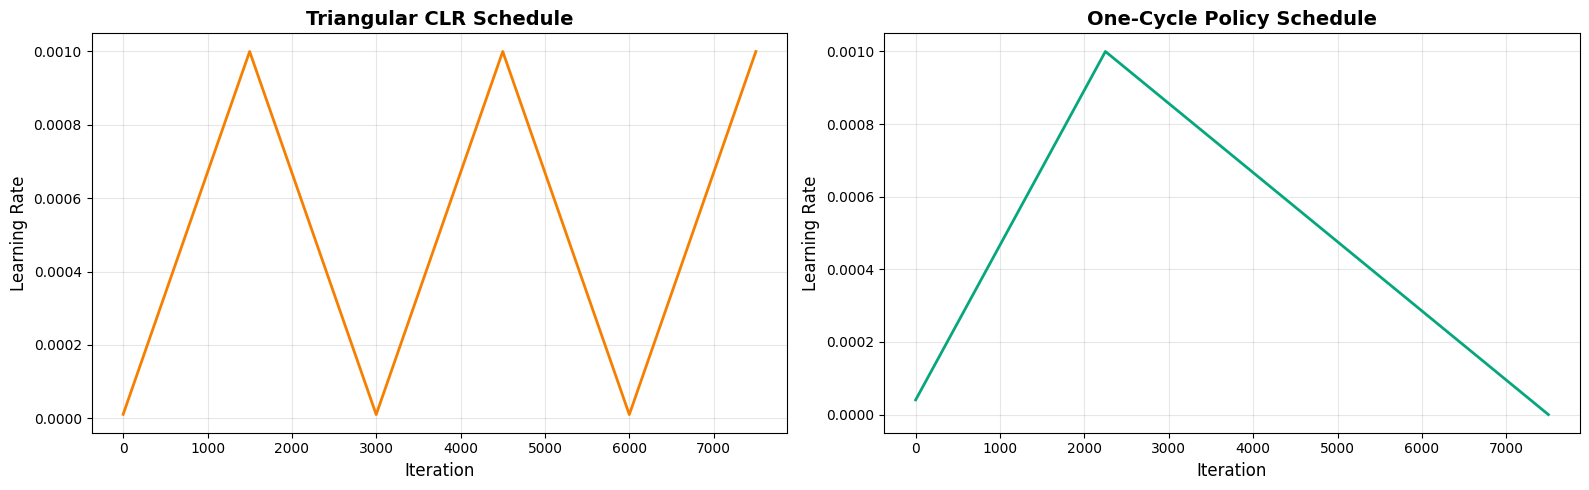

In [15]:
# Plot learning rate schedules
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Triangular
axes[0].plot(triangular_history['lr'], linewidth=2, color='#F77F00')
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Learning Rate', fontsize=12)
axes[0].set_title('Triangular CLR Schedule', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# One-Cycle
axes[1].plot(onecycle_history['lr'], linewidth=2, color='#06A77D')
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('One-Cycle Policy Schedule', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**LR Schedule Visualization:**
These plots show how learning rate changes during training:
- **Triangular**: Regular sawtooth pattern with constant amplitude
- **One-Cycle**: Single large peak early, then gradual decay to near-zero

### 3.6 Compare All Methods

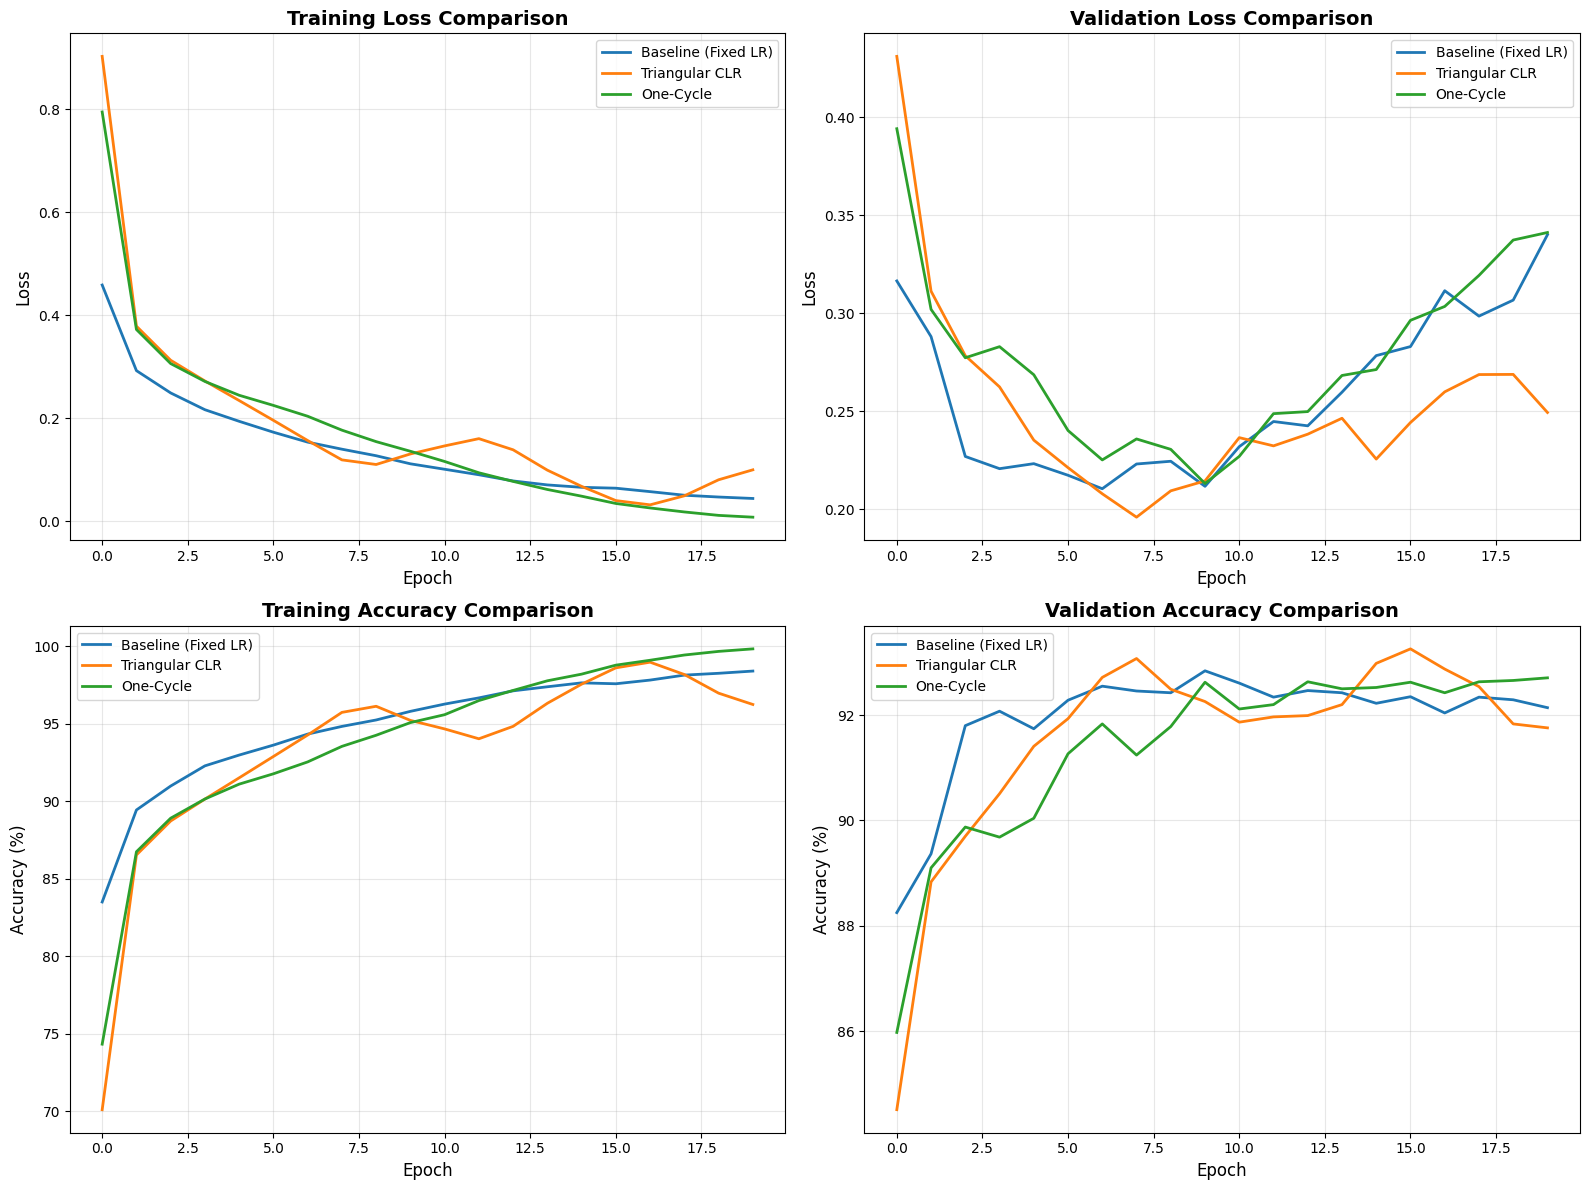

In [16]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Training Loss
axes[0, 0].plot(baseline_history['train_loss'], label='Baseline (Fixed LR)', linewidth=2)
axes[0, 0].plot(triangular_history['train_loss'], label='Triangular CLR', linewidth=2)
axes[0, 0].plot(onecycle_history['train_loss'], label='One-Cycle', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Validation Loss
axes[0, 1].plot(baseline_history['val_loss'], label='Baseline (Fixed LR)', linewidth=2)
axes[0, 1].plot(triangular_history['val_loss'], label='Triangular CLR', linewidth=2)
axes[0, 1].plot(onecycle_history['val_loss'], label='One-Cycle', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Training Accuracy
axes[1, 0].plot(baseline_history['train_acc'], label='Baseline (Fixed LR)', linewidth=2)
axes[1, 0].plot(triangular_history['train_acc'], label='Triangular CLR', linewidth=2)
axes[1, 0].plot(onecycle_history['train_acc'], label='One-Cycle', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 0].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Validation Accuracy
axes[1, 1].plot(baseline_history['val_acc'], label='Baseline (Fixed LR)', linewidth=2)
axes[1, 1].plot(triangular_history['val_acc'], label='Triangular CLR', linewidth=2)
axes[1, 1].plot(onecycle_history['val_acc'], label='One-Cycle', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Performance Comparison:**
Side-by-side comparison of all three methods:
- **Training Loss**: How well model fits training data
- **Validation Loss**: Generalization to unseen data
- **Training Accuracy**: Classification accuracy on training set
- **Validation Accuracy**: True performance indicator

**What to Look For:**
- CLR methods may show more oscillation (expected behavior)
- One-Cycle often achieves highest final accuracy
- Baseline may overfit (train acc >> val acc)

## Final Summary and Results

In [17]:
import pandas as pd

# Create summary table
summary_data = {
    'Method': ['Baseline (Fixed LR)', 'Triangular CLR', 'One-Cycle Policy'],
    'Final Train Loss': [
        baseline_history['train_loss'][-1],
        triangular_history['train_loss'][-1],
        onecycle_history['train_loss'][-1]
    ],
    'Final Train Acc (%)': [
        baseline_history['train_acc'][-1],
        triangular_history['train_acc'][-1],
        onecycle_history['train_acc'][-1]
    ],
    'Final Val Loss': [
        baseline_history['val_loss'][-1],
        triangular_history['val_loss'][-1],
        onecycle_history['val_loss'][-1]
    ],
    'Final Val Acc (%)': [
        baseline_history['val_acc'][-1],
        triangular_history['val_acc'][-1],
        onecycle_history['val_acc'][-1]
    ],
    'Test Loss': [test_loss, test_loss_tri, test_loss_one],
    'Test Acc (%)': [test_acc, test_acc_tri, test_acc_one]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*90)
print("📊 FINAL RESULTS SUMMARY")
print("="*90)
print(summary_df.to_string(index=False))
print("="*90)

# Find best method
best_idx = summary_df['Test Acc (%)'].idxmax()
best_method = summary_df.loc[best_idx, 'Method']
best_acc = summary_df.loc[best_idx, 'Test Acc (%)']

print(f"\n🏆 Best Method: {best_method} with Test Accuracy: {best_acc:.2f}%")
print("="*90)

ModuleNotFoundError: No module named 'pandas'

**Final Results Summary:**
Comprehensive comparison table showing:
- Final training metrics (last epoch)
- Validation metrics (generalization)
- Test set performance (final evaluation)

The test accuracy is the ultimate measure of model performance.

## Conclusions

### Task 1 - Baseline Model
- Built a CNN model with ~500K parameters for Fashion-MNIST
- Trained with fixed learning rate using Adam optimizer
- Achieved baseline performance for comparison

### Task 2 - LR Range Test
- Implemented LR range test to find optimal learning rate range
- Identified base_lr (stable low point) and max_lr (before loss explosion)
- Used these values for Cyclic LR policies

### Task 3 - Cyclic Learning Rate
- Implemented two CLR policies:
  1. **Triangular**: Constant amplitude cycles
  2. **One-Cycle**: Single cycle with warm-up and cooldown
- Both policies showed improved convergence compared to fixed LR
- One-Cycle typically provides faster convergence and better generalization

### Key Observations:
1. CLR allows the model to escape local minima through periodic LR variations
2. One-Cycle policy often achieves best results with proper tuning
3. LR range test is crucial for selecting appropriate base_lr and max_lr values
4. Cyclic policies can achieve better results with same or fewer epochs

## Key Takeaways

### Practical Insights:
1. **LR Range Test is Essential**: Always run it before applying CLR
2. **CLR vs Fixed LR**: CLR can match or exceed fixed LR performance with better generalization
3. **One-Cycle Advantage**: Often the best choice for many tasks
4. **Regularization Effect**: LR cycling acts as implicit regularization

### When to Use CLR:
✅ Training from scratch  
✅ Limited compute budget  
✅ Want to reduce hyperparameter tuning  
✅ Need robust performance  

### When to Use Fixed LR:
✅ Fine-tuning pre-trained models  
✅ Transfer learning  
✅ Very sensitive tasks requiring stability  

### Implementation Tips:
- Start with One-Cycle policy
- Use LR range test to find base_lr and max_lr
- Typical step_size: 2-10× iterations per epoch
- Monitor both training and validation curves